## Otorowiri

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape
import seaborn as sns

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

modules = utils.list_modules(loopflopy)
#for module in modules: print(module)

os.getcwd()

loopflopy.__file__


'c:\\users\\00105010\\projects\\loopflopy\\loopflopy\\__init__.py'

### 1. Setup Project

In [2]:
name = 'otorowiri'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe)
project.crs = 28350  # UTM zone 50S, EPSG:28350

project.mfexe

'../exe/mf6.exe'

### 2. Structural Model

#### 2.1 Bounding box

In [3]:
# A bounding box for structural model
x0, x1 = 320000, 400000
y0, y1 = 6670000, 6780000
z0, z1 = -1500, 400
bbox = [(x0, y0, z0), (x1, y1, z1)]

from loopflopy.spatial_routines import make_bbox_shp
crop_polygon = make_bbox_shp(x0, x1, y0, y1, crs=project.crs, fname = '../data/data_shp/structuralmodel.shp')

#### 2.2 Create the structural model object

In [4]:
# Create Structural Model object
geodata_fname = '../data/data_geology/bore_data_Otorowiri.xlsx'
data_sheetname = 'geodata_elevation'
strat_sheetname = 'strat'
from loopflopy.structuralmodel import StructuralModel
#spatial and bbox come from the spatial module, excel file and sheet names are user defined
structuralmodel = StructuralModel(bbox, geodata_fname, data_sheetname, strat_sheetname)

#### 2.3 Clip the DEM to the structural model

In [5]:
# Clip DEM to structuralmodel
import process_dem

original_asc_path     = '../data/data_elevation/rasters_COP30/output_hh.asc'
crop_polygon_shp_path = '../data/data_shp/structuralmodel.shp'
output_tif_path       = '../data/data_dem/structuralmodel_dem.tif'
#process_dem.model_DEM(original_asc_path, crop_polygon_shp_path, output_tif_path) #only need to do once! About 5min

from loopflopy.dem import DEM
geotiff_fname = '../data/data_dem/structuralmodel_dem.tif'
dem_structural = DEM(geotiff_fname = geotiff_fname)
#dem_structural.plot_geotiff()

In [6]:
#help(dem_structural.resample_topo)

#### 2.4 Resample DEM to raster mesh

USING MALVINAS VERSION
No special cells
EPSG:28350
EPSG:28350


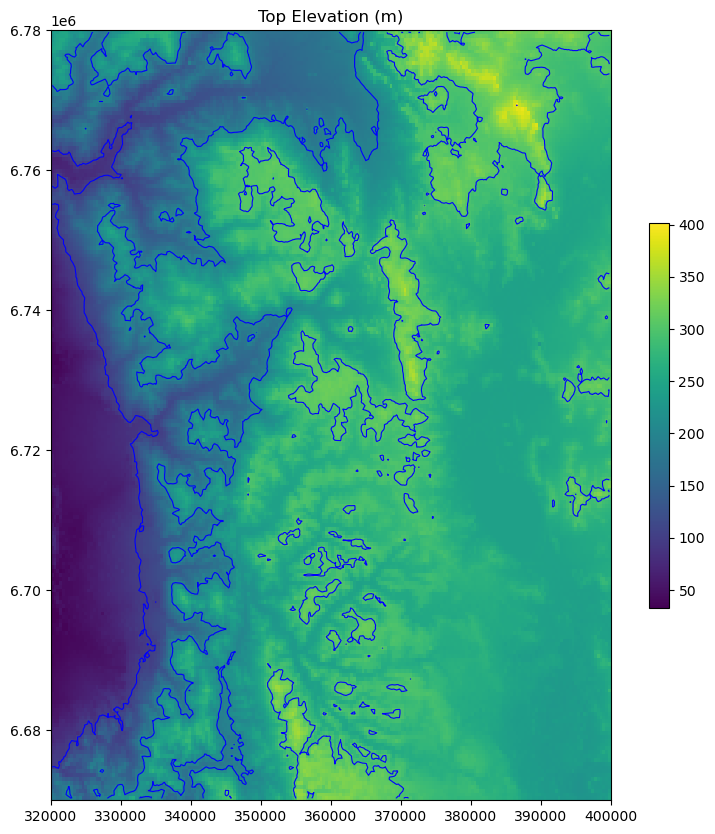

In [7]:
# Resample DEM to raster mesh
from loopflopy.mesh_routines import create_structured_mesh
dem_grid = create_structured_mesh(bbox, ncol = 200, nrow = 200, crs = project.crs)

dem_structural.resample_topo(dem_grid, fname = '../modelfiles/structural_topo.pkl') # only need to run when mesh changes. Take 1-2 minutes
dem_structural.load_topo(fname = '../modelfiles/structural_topo.pkl')
dem_structural.plot_topo(dem_grid, levels = [0, 100, 200, 300, 400, 500, 600, 700])

structuralmodel.topo = dem_structural.topo
structuralmodel.mesh = dem_grid

In [8]:
# Just keep yjis for a bit
#def find_elevation(row):
#    point = Point(row['Easting'], row['Northing'])
#    cell = structuralmodel.mesh.gi.intersect(point)["cellids"][0]
#    z = structuralmodel.topo[cell]
#    return z
#
#df = pd.read_excel(structuralmodel.geodata_fname, sheet_name='geo_boundaries') #Refer to the geology spreadsheet
#df['Ground_dem'] = df.apply(lambda row: find_elevation(row), axis=1)
    

#### 2.5 Process structural model from spreadsheet

In [9]:
import process_structural

process_structural.geo_boundaries(project, structuralmodel, crop_polygon, simplify_tolerance =1000, node_spacing = 2000)
process_structural.prepare_strat_column(structuralmodel)
process_structural.add_geo_boundaries(structuralmodel)
#process_structural.elevation_fill_all(structuralmodel) #this will fill all the boreholes with DEM elevations
process_structural.elevation_fill_unknown(structuralmodel) #this will fill only the boreholes with no elevation data
process_structural.prepare_geodata(structuralmodel)
process_structural.create_structuralmodel(structuralmodel)

#structuralmodel.model.to_file('../modelfiles/structuralmodel') #pickle the model to send to people
#structuralmodel.data.to_excel('../modelfiles/structuraldata.xlsx', index=False) # Check the data used for structural model
#structuralmodel.strat.to_excel('../modelfiles/structuralstrat.xlsx', index=False) # Check the stratigraphy used for structural model

     sequence    unit    R    G    B   val  lithid Thickness  iconvert    hk  \
0      Ground  Ground  255  255  255     0      -1         -       NaN   NaN   
1  Yarragadee      Kp  172  186  242   124       0       NaN       1.0   8.0   
2  Yarragadee     Kpo  117  128  229   100       1       NaN       0.0   0.1   
3  Yarragadee      Jy  198  217  240 -1000       2       NaN       0.0  10.0   

     vk       ss    sy     Unnamed: 13  
0   NaN      NaN   NaN             NaN  
1   0.1  0.00010  0.10  hk should be 8  
2   0.1  0.00001  0.01             NaN  
3  10.0  0.00001  0.20             NaN  

Updated DataFrame with geo_boundaries written to new sheet: 'geo_boundaries' in file: ../data/data_geology/bore_data_Otorowiri.xlsx
DEM bounds:
  xmin (left):   319999.2808458023
  ymin (bottom): 6669986.956668399
  xmax (right):  400000.3649361293
  ymax (top):    6780029.0232758615
  CRS:           EPSG:28350
DataFrame coordinate extents:
  Easting:  min = 333143.0, max = 375240.0
  North


Updated DataFrame written to new sheet: 'structuralmodel_data' in file: ../data/data_geology/bore_data_Otorowiri.xlsx
1.6.13


c:\Users\00105010\Anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [10]:
'''import pyvista
from LoopStructural.visualisation import Loop3DView
view = Loop3DView(structuralmodel.model)
view.plot_surface(structuralmodel.model['Yarragadee'], [124])
#view.plot_model_surfaces()
view.plot_data(structuralmodel.model['Yarragadee'])
view.set_scale(zscale = 10)
view.show()'''

"import pyvista\nfrom LoopStructural.visualisation import Loop3DView\nview = Loop3DView(structuralmodel.model)\nview.plot_surface(structuralmodel.model['Yarragadee'], [124])\n#view.plot_model_surfaces()\nview.plot_data(structuralmodel.model['Yarragadee'])\nview.set_scale(zscale = 10)\nview.show()"

#### 2.6 Plot cross-sections of the structural model

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(9600,) (9600,) (9600,)
V shape (120, 80)


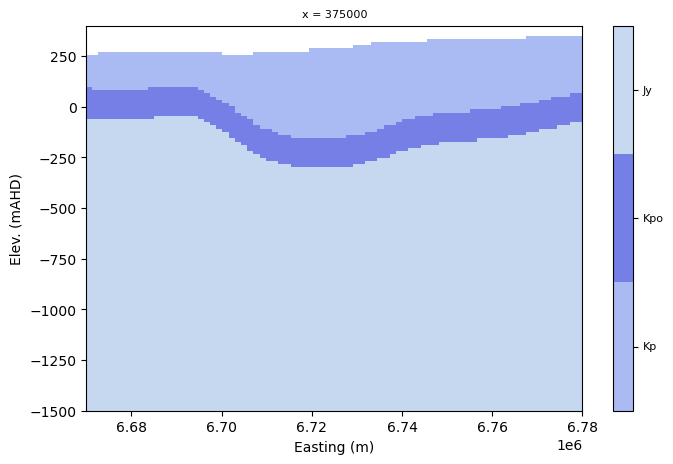

['Ground', 'Yarragadee']


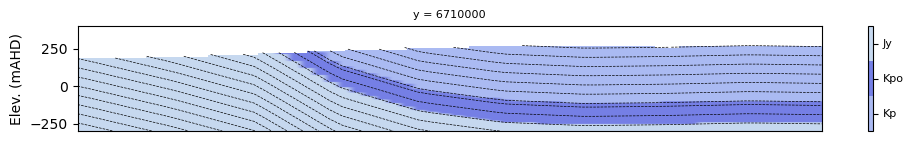

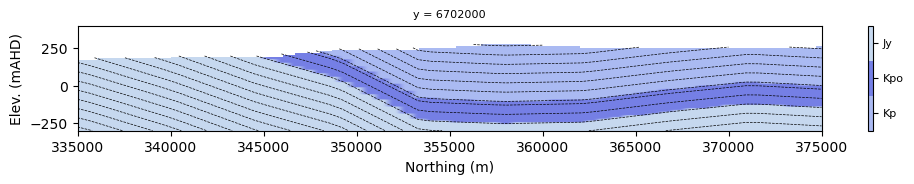

In [11]:
z0 = -300 # just for plotting. Make sure within bbox of structural model
z1 = 300   # just for plotting. Make sure within bbox of structural model
nh, nz = 90, 90 # plotting resolution

transect_x = [375000]#, 400000, 410000]
# DONGARA LINE - 6750000
# ENEABBA LINE - 6700000
transect_y = [6760000, 6730000]# 6700000]
structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 120)#, x1 = 6520000, z0 = -2000) 
#structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 120, z0 = -1000) 

transect_y = [6710000, 6702000]
structuralmodel.plot_ytransects2(transect_y, nx = 60, nz = 60, dz = 10, x0 = 335000, x1 = 375000, z0 = -300, z1 = 400) #x0 = 335000, x1 = 352000, z0 = -200, z1 = 300


In [12]:
#for i in range(len(spatial.xsections)):
#    start = spatial.xsections[i][0]
#    end   = spatial.xsections[i][1]

#    structuralmodel.plot_xytransect(title = spatial.xsection_names[i], start = start, end = end, z0 = z0-1000, z1 = z1+1000, nh = nh, nz = nz)

#structuralmodel.contour_bottom(spatial, contour_interval = 10) #unit = 'Kp', 

### 3. Surface Refinement

In [13]:
from loopflopy.surfacerefinement import SurfaceRefinement
surfacerefinement = SurfaceRefinement(structuralmodel, nrow = 200, ncol = 200)
surfacerefinement.create_surf_lith_raster(structuralmodel) # This takes about 48seconds

Max ground level =  311.0
Min ground level =  169.0
No special cells
number of cells in plan =  40000
   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  5.829279
   1. Evaluating structural model...
len(xyz) =  5840000
Time taken Block 1 (Evaluate model) =  28.034105
   2. Creating geo model layers...
stop_array shape (4, 40000)
nlay =  146
ncpl =  40000
nlg number of geo layers =  3
Time taken Block 2 create geomodel layers  0.985361
   3. Evaluating geo layer thicknesses...
Time taken Block 3 tiny bit 0.0
   4. Creating flow model layers...
Time taken Block 4 create flow model layers =  0.050439
   5. Calculating gradients...
Time taken Block 5 gradients=  2.917467


#### 3.1 Surfaces from structural model

In [14]:
# Create surfaces from the structural model
# This will create surfaces for each stratigraphic unit in the model
structuralmodel.make_surfaces()
bot_parm = structuralmodel.surfaces[1]

     
Creating surface for feature: Ground, lithid -1, value: 0
number of vertices =  2752
     
Creating surface for feature: Yarragadee, lithid 0, value: 124
number of vertices =  2420
     
Creating surface for feature: Yarragadee, lithid 1, value: 100
number of vertices =  2730


#### 3.2 Plotting the bottom of the Parmelia

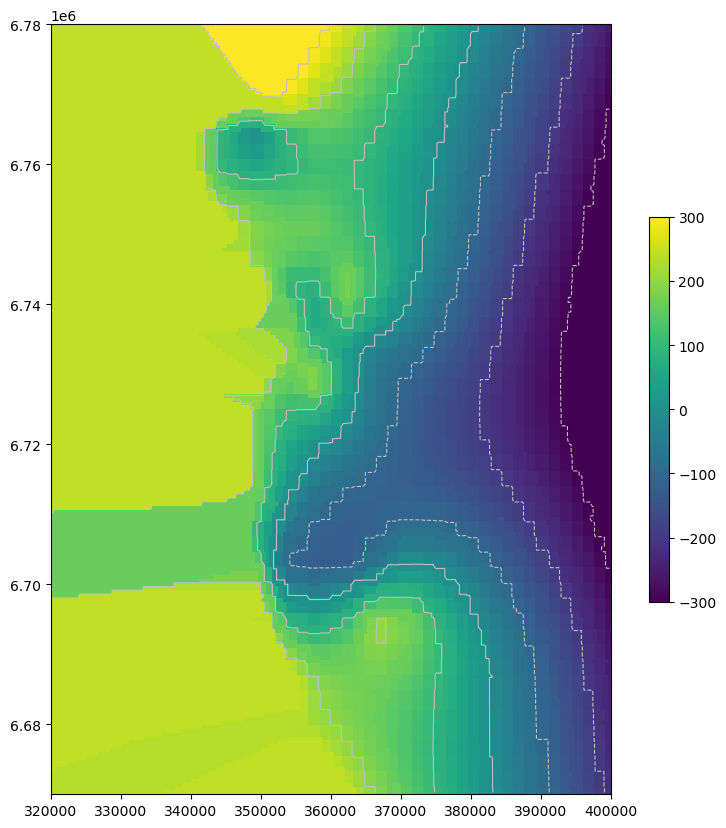

In [15]:
#dir(surfacerefinement.geomodel) #.plot_surface(surfacerefinement.geomodel.top_geo)
# Bottom of Parmelia
array = bot_parm #structuralmodel.topo - bot_parm
title = 'title'
surfacerefinement.mesh.plot_surface_array(array, structuralmodel, vmin = -300, vmax = 300)


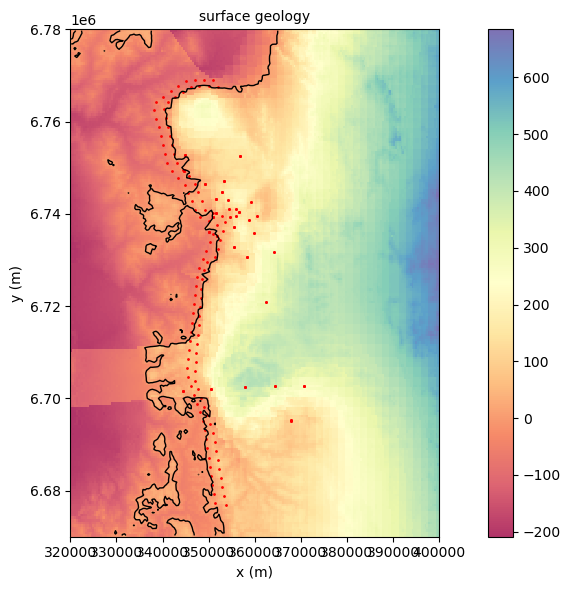

c:\users\00105010\projects\loopflopy\loopflopy\surfacerefinement.py:116: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


In [16]:
array1 = structuralmodel.topo # 1D
array2 = bot_parm # 1D
surfacerefinement.array_intersection(project, structuralmodel, array1, array2, plot_datapoints = True)

#### 3.3 Plotting outcropping lithologies (using Kerry surface refinement)

In [17]:
#surfacerefinement.surface_contours(project, structuralmodel, plot_datapoints = True)

### 4. Model boundary

#### 4.1 Retreiving boundaries from surface lithology outcrops

In [18]:
'''####Use this way of getting boundary linestrings from outcrop geology
## NOTE: May not work if the geology has complex surface outcroppings, which may cause pinched cells with flow issues

import process_boundary
raw_lines, labels = process_boundary.gather_boundary_linestrings(project)
process_boundary.plot_linestrings(raw_lines, labels)
trimmed_lines = process_boundary.trim_boundary_linestrings(raw_lines)
process_boundary.plot_linestrings(trimmed_lines, labels)
snapped_lines = process_boundary.snap_linestring_endpoints(trimmed_lines, tolerance=1000)  # 5 units tolerance, adjust as needed
model_boundary_poly = process_boundary.make_boundary_polygon(trimmed_lines, snapped_lines)'''

'####Use this way of getting boundary linestrings from outcrop geology\n## NOTE: May not work if the geology has complex surface outcroppings, which may cause pinched cells with flow issues\n\nimport process_boundary\nraw_lines, labels = process_boundary.gather_boundary_linestrings(project)\nprocess_boundary.plot_linestrings(raw_lines, labels)\ntrimmed_lines = process_boundary.trim_boundary_linestrings(raw_lines)\nprocess_boundary.plot_linestrings(trimmed_lines, labels)\nsnapped_lines = process_boundary.snap_linestring_endpoints(trimmed_lines, tolerance=1000)  # 5 units tolerance, adjust as needed\nmodel_boundary_poly = process_boundary.make_boundary_polygon(trimmed_lines, snapped_lines)'

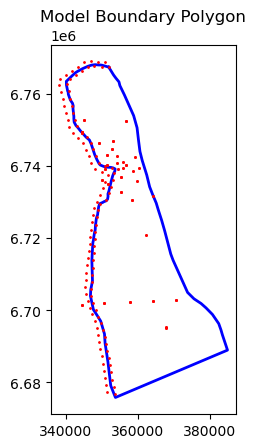

In [19]:
import process_boundary

shapefile_path = '../data/data_geology/Otorowiri_outcrop.xlsx'

model_boundary_poly = process_boundary.boundary_from_shapefile(shapefile_path, structuralmodel)

### 5. Spatial

#### 5.1 Set basics as spatial objects

POLYGON ((361337.20725018514 6735522.680110534, 361318.55532478204 6735525.34676506, 361300.2371096979 6735529.756794962, 361282.41518154956 6735535.871060632, 361265.24771234096 6735543.635297142, 361248.8870656651 6735552.98059585, 360589.151451948 6735972.229061367, 360574.4827576252 6735982.500582804, 359975.5522891828 6736443.188638042, 359972.66517840134 6736445.4518035585, 359627.74982986867 6736720.970266216, 359160.85397186875 6737035.591168093, 358646.0471174668 6737374.582637623, 358631.7419482652 6737384.935738192, 358618.4057506354 6737396.510296069, 358606.14248842536 6737409.21608047, 358595.04776129295 6737422.954042004, 358178.78923114884 6737987.677366506, 358168.802181669 6738002.582821196, 358160.19113841595 6738018.3233317, 357803.21527111484 6738746.661997532, 357802.45015107194 6738748.240553889, 357439.64677841234 6739505.1979318485, 356985.1587132632 6739946.094619135, 356649.4186185305 6740144.445396702, 355987.0582307656 6740394.382825348, 355969.0571409932 6

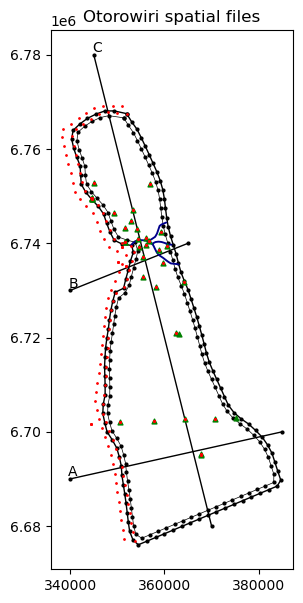

In [20]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = project.crs)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 0, node_spacing = 2000)
process_spatial.geo_bores(spatial)
process_spatial.obs_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.arrow(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)
#process_spatial.rivers(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)
#process_spatial.outcrop(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)

spatial.xsection_names = ['A', 'B', 'C']
spatial.xsections = [
                     [(340000, 6690000),(385000, 6700000)], 
                     [(340000, 6730000),(365000, 6740000)],
                     [(345000, 6780000),(370000, 6680000)]
                     ]

#extent = [[330000, 370000],[6740000, 6770000]] #[[342000, 370000],[6725000, 6745000]] # extent[[x0,x1], [y0,y1]]
extent = [[330000, 370000],[6680000, 6770000]]
process_spatial.plot_spatial(spatial, structuralmodel,
                 labels = False, # Bore ids
                 obsbores = False, 
                 pumpbores = False, 
                 geobores = True, 
                 rivers = False, # thre three river
                 arrow = True, # Just arrowsmith
                 structuralmodel_data = True,
                 xsections = True,
                 #extent = extent # Just hash out to see the whole model
                 ) 

In [21]:
m = spatial.obsbore_gdf.explore()#location=[-31.4, 115.8], zoom_start=11, popup = 'ID')
#m = folium.Map(location=[52.0, 4.0], zoom_start=6) 
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')

#### 5.2 Add vegetation as multipolygons in spatial object

In [22]:
import process_recharge

model_boundary = gpd.read_file('../data/data_shp/model_boundary.shp')

# ONLY need to do this when the model boundary changes
#process_recharge.clip_veg_to_model(spatial, model_boundary) # Just need to do when boundary changes! Or could clip to structural model then don't need to do it all the time? 
#process_recharge.print_clipped_veg_figures(model_boundary) # create figures to visualise vegetation changes over time

with open('../data/data_woody/clipped_woody/veg_multipolygons_by_year.pkl', 'rb') as f:
    veg_multipolygons_by_year = pickle.load(f)

In [23]:
#check calling the saved multipolygons (these are not yet on the mesh we need - but they are clipped to the model boundary)
for year, multipoly in veg_multipolygons_by_year.items():
    setattr(spatial, f"veg_{year}_multipoly", multipoly) # this will add the multipolygon to the spatial module
getattr(spatial, "veg_1985_multipoly")
veg_multipolygons_by_year['1985']

### 6. Mesh

#### 6.1 Mesh essentials and identifying special cells

arrow_nodes
number of cells in plan =  6013


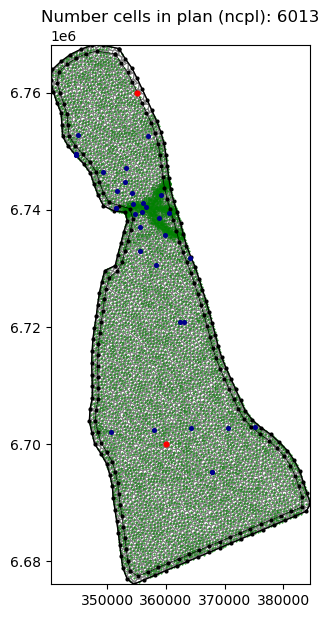

In [24]:
from loopflopy.mesh import Mesh
# groups: obs, wel, chd, ghb, poly

special_cells = {
                 #'rivers': ['arrow'],
                 #'wel': ['pumpbores'], 
                 'obs': ['obsbores'],
                 'poly': ['arrow'],
                 'multipoly': ['veg_1972', 'veg_1985'] #list(veg_multipolygons_by_year.keys())
                 }
mesh = Mesh(plangrid = 'vor', special_cells = special_cells) # special cells to identify as arguements

mesh.modelmaxtri = 300000 # was 400000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 200 # radius of inner circle around pumping bores
mesh.radius2 = 600 # radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['arrow_nodes']#'bore_refinement_nodes']
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

xlim = extent[0]
ylim = extent[1]
features = ['wel', 'obs', 'arrow']
mesh.plot_cell2d(spatial, features, xlim = None, ylim = None, nodes = False, labels = False) # Just exclude xlim, ylim if plotting whole thing

#### 6.2 Find Cell IDs of spatial features

Group =  obs ['obsbores']
flag = 1
Group =  poly ['arrow']
flag = 2
poly_arrow_cells
Group =  multipoly ['veg_1972', 'veg_1985']
flag = 3
Processing multipoly group...
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_angrot', '_botm', '_build_grid_geometry_info', '_cache_dict', '_cell1d', '_cell2d', '_copy_cache', '_crs', '_edge_set', '_grid_type', '_has_ref_coordinates', '_idomain', '_iverts', '_laycbd', '_lenuni', '_load_settings', '_ncpl', '_neighbors', '_nlay', '_polygons', '_prjfile', '_require_cache_updates', '_set_neighbors', '_top', '_units', '_vertices', '_verts', '_xoff', '_xul_to_xll', '_yoff', '_yul_to_yll', '_zcoords', 'angrot', 'angrot_radians', 'attribs_from_namf

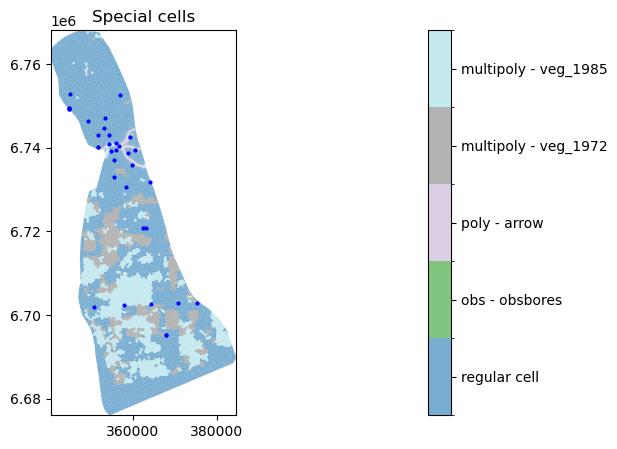

In [25]:
#output_folder = '../data/data_woody/woody_cells' # folder to save the special cells
mesh.locate_special_cells(spatial, threshold = 0.4) #the threshold here controls how much of a cell should be covered by the polygon to create a 'special cell'
mesh.plot_feature_cells(spatial) #, xlim, ylim)

#### 6.3 Overlay DEM over mesh

Clipped GeoTIFF saved to: ../Data/data_dem/Otorowiri_Geomodel_DEM.tif
-9999.0


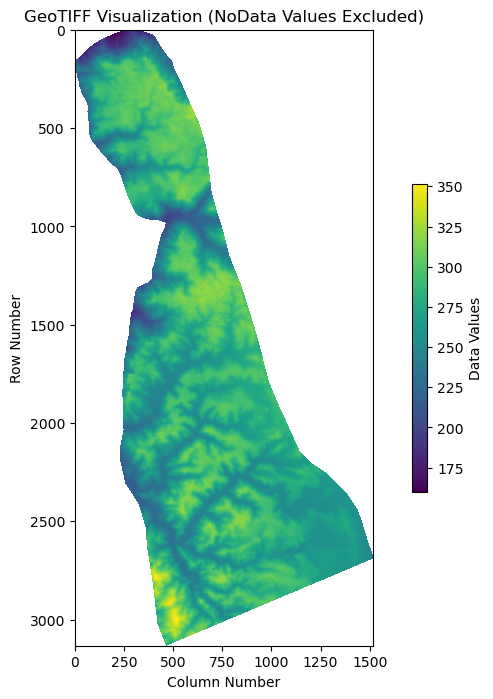

None
EPSG:28350


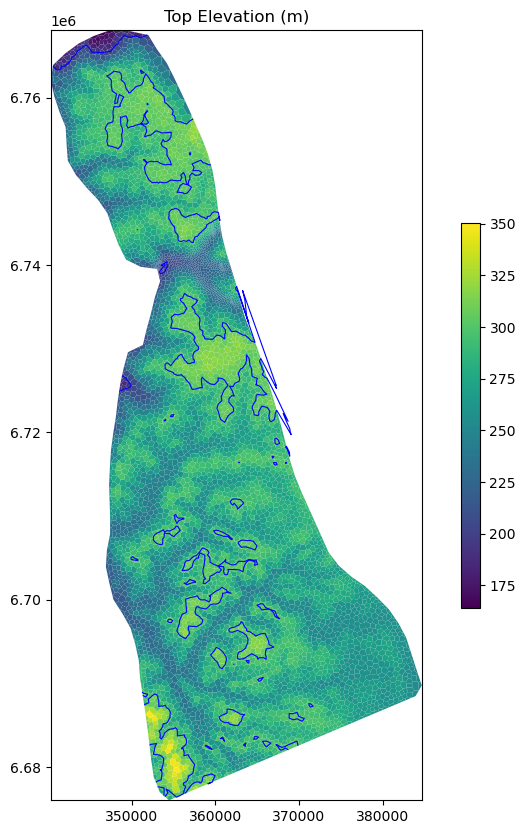

In [26]:
##here clip model to the geological model boundary
original_tiff_path    = '../data/data_dem/structuralmodel_dem.tif' #Otorowiri_Model_DEM.tif'
crop_polygon_shp_path = '../data/data_shp/model_boundary.shp'
output_tiff_path      = '../Data/data_dem/Otorowiri_Geomodel_DEM.tif'
process_dem.crop_geotiff(original_tiff_path, crop_polygon_shp_path, output_tiff_path)

dem_geomodel = DEM(geotiff_fname = output_tiff_path)
dem_geomodel.plot_geotiff()

#resample DEM to mesh
dem_geomodel.resample_topo(mesh, fname = '../modelfiles/geomodel_topo.pkl') # only need to run when mesh changes. Take 1-2 minutes
dem_geomodel.load_topo(fname = '../modelfiles/geomodel_topo.pkl')
dem_geomodel.plot_topo(mesh, levels = [0, 100, 200, 300, 400, 500, 600, 700])

### 7. Geomodel

#### 7.1 Set up geomodel (lithological block of cells)

In [27]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -300, 300 

from loopflopy.geomodel2 import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 4, res = 1, nlg = 1) # include nlg if you only want some of the top geo layers included in flow model
geomodel.evaluate_structuralmodel(mesh, structuralmodel)
geomodel.create_model_layers(mesh, structuralmodel, dem_geomodel)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  4.105701

   1. Evaluating structural model...
len(xyz) =  3607800
Time taken Block 1 (Evaluate model) =  18.393923

   2. Creating geo model layers...
ncpl =  6013
nlg number of geo layers =  1
[50 50 25]
     
Creating surface for feature: Ground, lithid -1, value: 0
number of vertices =  2752
len filtered z  2752  i.e. without NaN or inf
(array([204.40750122, 206.72789415, 207.2429498 , 209.39799945,
       213.35702737, 216.33818944, 217.47248967, 220.00382741,
       220.55119673, 223.07845751, 223.78497918, 224.96004899,
       225.08099874, 226.13315582, 227.50482559, 227.7452151 ,
       229.45995331, 229.63798046, 231.09692732, 232.4876229 ,
       233.65982374, 234.03278987, 234.06525453, 234.46207841,
       235.01699766, 235.33409437, 235.34617424, 235.74254513,
       235.78497569, 235.81321239, 237.01334794, 237.03207175,
       237.53972848, 237.85244624, 238.09313774, 238.23734125,
       238.2849057

#### 7.2 Visual checks of geomodel set-up

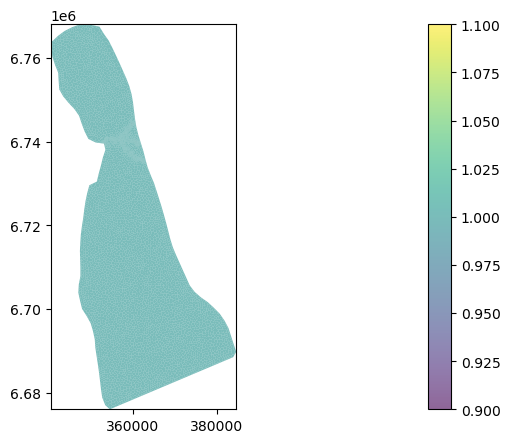

In [28]:
geomodel.plot_surface(geomodel.idomain_geo) # Yellow plots negative or zero thickness

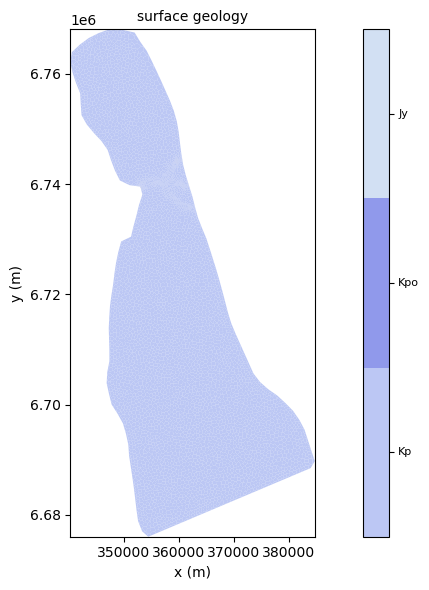

c:\users\00105010\projects\loopflopy\loopflopy\geomodel2.py:640: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


In [29]:
# Surface lithology
geomodel.get_surface_lith()
geomodel.geomodel_plan_lith(spatial, mesh, structuralmodel)

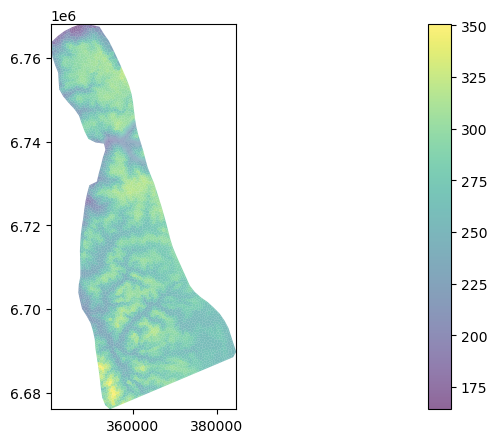

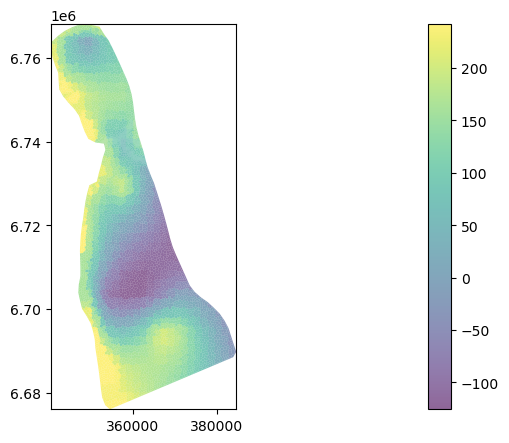

In [30]:
# Geomodel top, bottom of layer 0
geomodel.plot_surface(geomodel.top_geo)
geomodel.plot_surface(geomodel.botm_geo[0])


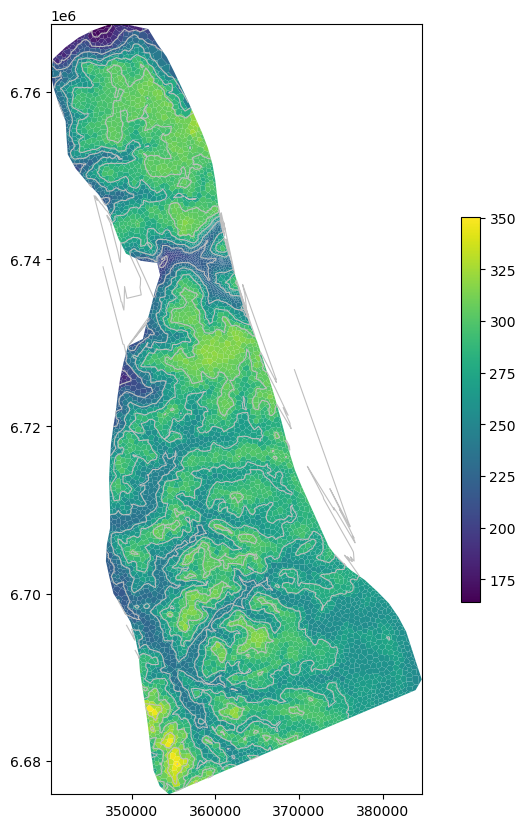

In [31]:
# Different way of plotting top
array = geomodel.top_geo
mesh.plot_surface_array(array, structuralmodel)

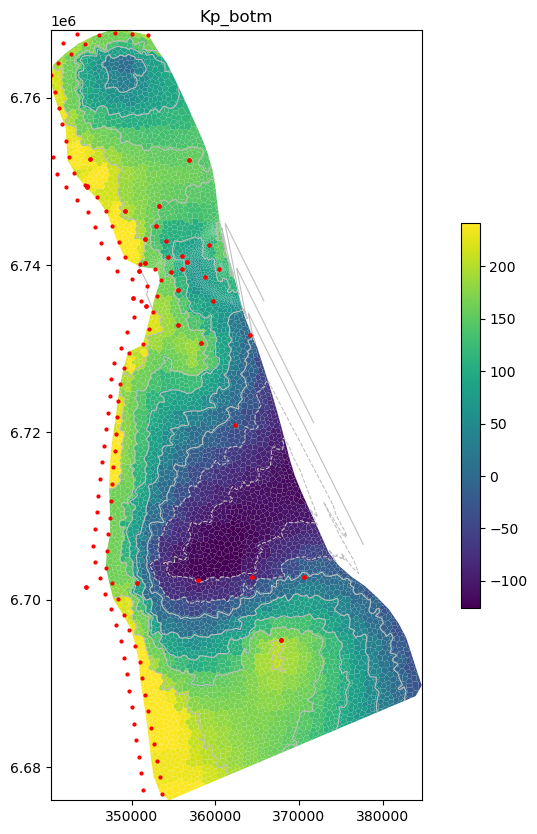

In [32]:
# Bottom of Parmelia
array = geomodel.botm_geo[0] # Botm Kp
title = 'Kp_botm'
mesh.plot_surface_array(array, structuralmodel, title = title, plot_data = True, lithcode = 'Kp')

In [33]:
print(dir(mesh))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'angle', 'boremaxtri', 'boundmaxtri', 'cell2d', 'cell_type', 'chd_cells', 'create_bore_refinement', 'create_mesh', 'drn_cells', 'ghb_cells', 'gi', 'ibd', 'idomain', 'lak_cells', 'locate_special_cells', 'modelmaxtri', 'ncpl', 'nodes', 'obs_cells', 'plangrid', 'plot_cell2d', 'plot_feature_cells', 'plot_surface_array', 'poly_arrow_cells', 'poly_cells', 'polygons', 'prepare_nodes_and_polygons', 'radius1', 'radius2', 'special_cells', 'veg_1972_cells', 'veg_1985_cells', 'vertices', 'vgrid', 'vor', 'wel_cells', 'welnodes', 'welnodes2', 'xc', 'xcyc', 'yc']


In [34]:
# Parmelia thickness
Kp_thick = geomodel.top_geo - geomodel.botm_geo[0] 
print('Kp has ', np.sum(Kp_thick < 10), ' negative thickness values')
#plot where this is --> location
print('Kp has min geo thickness of ', np.min(Kp_thick), ' m')

#ids_to_investigate = np.where(Kp_thick < 10)[0]  # 1D array of cell IDs
ids_to_investigate = np.where((Kp_thick > 1) & (Kp_thick < 2))[0]
print("Negative thickness cell IDs:", ids_to_investigate)

#utils.plot_cell_thickness(mesh, geomodel)

Kp has  172  negative thickness values
Kp has min geo thickness of  0.37306722005200754  m
Negative thickness cell IDs: [2107 4124 4615 4629 5580]


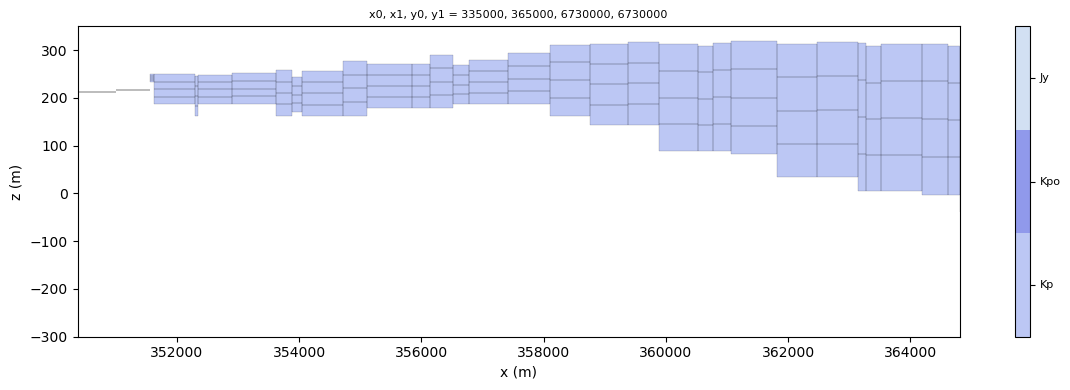

In [35]:
# Geomodel transect
y0, y1 = 6730000, 6730000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1, x0 = 335000, x1 = 365000, z0 = -300, z1 = 350)# z0 = -200, z1 = 300


### 8. Import existing environmental data for model compatibility

#### 8.1 Precipitation data from BOM

In [36]:
'''import process_precipitation

# Clean precipitation data for the whole dataset
process_precipitation.clean_precipitation()
process_precipitation.average_precipitation()
#process_precipitation.plot_full_precipitation()

# Creating csv summary of wet and dry years
process_precipitation.create_precip_summary() #this creates a csv file with the summary of wet and dry periods
process_precipitation.start_end_seasons()'''

'import process_precipitation\n\n# Clean precipitation data for the whole dataset\nprocess_precipitation.clean_precipitation()\nprocess_precipitation.average_precipitation()\n#process_precipitation.plot_full_precipitation()\n\n# Creating csv summary of wet and dry years\nprocess_precipitation.create_precip_summary() #this creates a csv file with the summary of wet and dry periods\nprocess_precipitation.start_end_seasons()'

#### 8.2 Groundwater levels from WIR

Saved chunk 1 with 999 IDs to: ../data/data_waterlevels/obs/bore_id_chunks\bore_id_list_01.txt
Saved chunk 2 with 999 IDs to: ../data/data_waterlevels/obs/bore_id_chunks\bore_id_list_02.txt
Saved chunk 3 with 201 IDs to: ../data/data_waterlevels/obs/bore_id_chunks\bore_id_list_03.txt
2199 BORE_IDs written to: ../data/data_waterlevels/obs/bore_id_list.txt
CRS mismatch: reprojecting observation points to match model boundary.
303 bore points retained within model boundary.
Filtered bore ID list written to: ../data/data_waterlevels/obs/filtered_bore_ids.txt


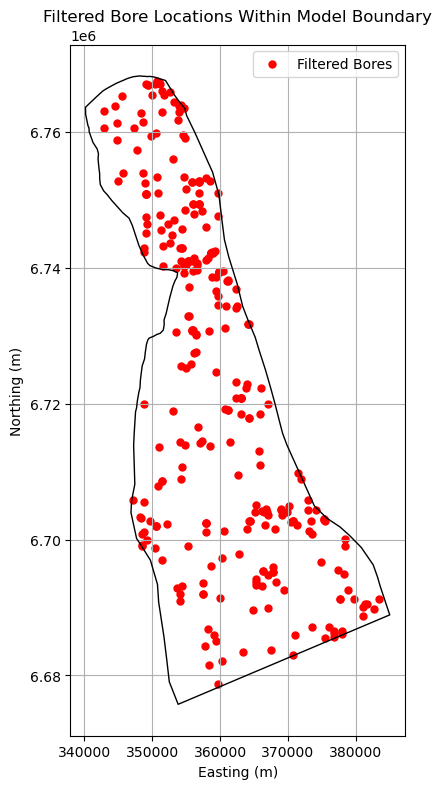

278 site records matched to model bore IDs.
244 bores retained after filtering out zero-depth with no screen info.
The bores ['Ds M7B', 'Bore', 'Bore'] have assumed drill depths based on screen information.
207 bores retained after filtering for Parmelia aquifer.
147 bores had 'zobs' filled in using (Elevation_DEM - Drilled Depth / 2).
6 duplicate screened intervals merged into single entries.
141 bores retained that contain some water level information.
102 bores retained that have valid sample years.
Unique bore IDs in water level data from Water level file: 180
Unique bore IDs in water level data after filtering to Parmelia and dropping where there's no WL data: 90


c:\Users\00105010\Projects\Otorowiri\scripts\process_filtering.py:354: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  period_ranges = pd.read_csv(seasonal_df, parse_dates=['Start', 'End'])


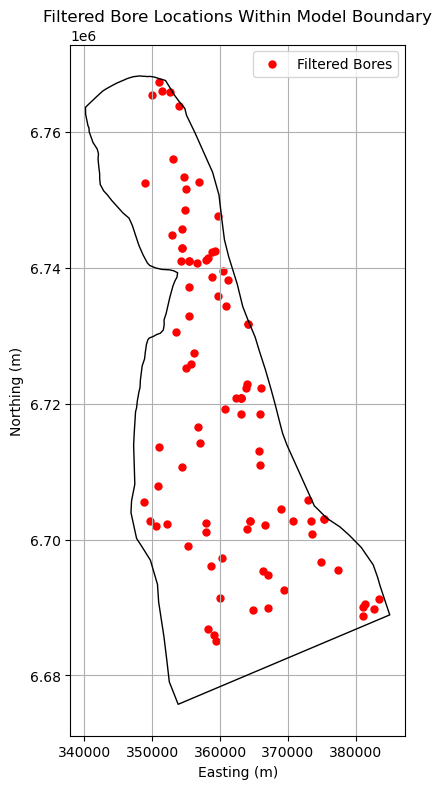

Using earliest timeframe with ≥10 bores: 1969_Wet


In [37]:
import process_filtering
# Create a bore list from the DWER bore spatial data to extract everything possible from WIR (this will then be iterative depending on model boundary changes)
process_filtering.create_bore_list()

# Trim the data from the large DWER bore data extract to the Otorowiri Shapefile boundary (spatial filter)
geomodel_shapefile = '../data/data_shp/model_boundary_polygon.shp'
bores_in_model = process_filtering.trim_obs_to_shape(geomodel_shapefile)

# For all the bores contained within the Otorowiri model bounds, assign the aquifer based on screen or bore depth
process_filtering.create_merged_obs(bores_in_model)
process_filtering.fill_bore_elevations()
process_filtering.assign_aquifer(mesh, geomodel)

# create the dataframes that will be used for the obs file in flopy - both transient and steady state
seasonal_df = '../data/data_precipitation/start_end_seasons.csv'
process_filtering.filtered_transient_obs(geomodel_shapefile, seasonal_df)
process_filtering.extract_steady_state()

# if data needs to be visualised, hydrographs can be made for all the wells with timeseries data
# and 
#process_observations.plot_hydrograph(df_boredetails, spatial)
#process_filtering.plot_seasonal_flows(geomodel_shapefile)

#### 8.3 Surface water levels from WIR

In [38]:
'''import process_surfaceflows

continuous_df = pd.read_excel('../data/data_surfacewater/174345/WaterLevelsContinuousForSiteCrossTab.xlsx')
discrete_df = pd.read_excel('../data/data_surfacewater/174344/WaterLevelsDiscreteForSiteCrossTab.xlsx')

# Plot the surface flow data
process_surfaceflows.plot_surfaceflows(continuous_df, discrete_df)

# Calculate what needs to be calculated for the model...'''


"import process_surfaceflows\n\ncontinuous_df = pd.read_excel('../data/data_surfacewater/174345/WaterLevelsContinuousForSiteCrossTab.xlsx')\ndiscrete_df = pd.read_excel('../data/data_surfacewater/174344/WaterLevelsDiscreteForSiteCrossTab.xlsx')\n\n# Plot the surface flow data\nprocess_surfaceflows.plot_surfaceflows(continuous_df, discrete_df)\n\n# Calculate what needs to be calculated for the model..."

#### 8.4 Evaporation levels from SILO

https://www.longpaddock.qld.gov.au/silo/point-data/

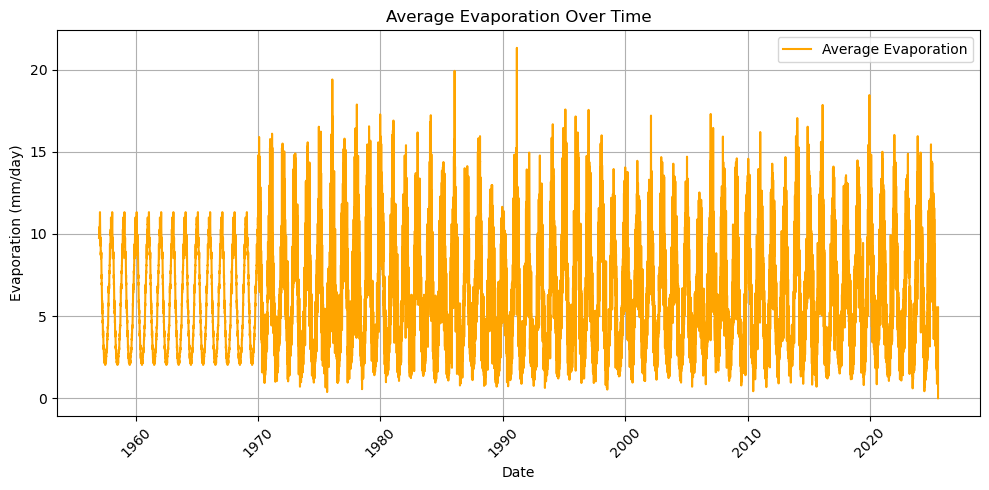

In [39]:
import process_evaporation

#process_evaporation.plot_evaporation_data()
#process_evaporation.create_average_evaporation_df()
process_evaporation.plot_average_evaporation()

#summarised data for every season
seasonal_df = '../data/data_precipitation/start_end_seasons.csv'




### 9. Assign hydrogeological parameters to geomodel cells

In [40]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'strat')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = [0., 0., 0.] #props.iconvert.tolist() # #

geomodel.fill_cell_properties(mesh)
print(geomodel.hk_perlay)
print(geomodel.iconvert_perlay)  # Check the properties are filled correctly
props


   6. Filling cell properties...
ang1 shape  (4, 6013)
24052
angle1 shape  (24052,)
Time taken Block 6 Fill cell properties =  0.001
[8.0, 0.1, 10.0]
[0.0, 0.0, 0.0]


index    sequence unit    R    G    B   val  lithid Thickness  iconvert  \
0      1  Yarragadee   Kp  172  186  242   124       0       NaN       1.0   
1      2  Yarragadee  Kpo  117  128  229   100       1       NaN       0.0   
2      3  Yarragadee   Jy  198  217  240 -1000       2       NaN       0.0   

     hk    vk       ss    sy     Unnamed: 13  
0   8.0   0.1  0.00010  0.10  hk should be 8  
1   0.1   0.1  0.00001  0.01             NaN  
2  10.0  10.0  0.00001  0.20             NaN

### 10. Create data packages for flowmodel

#### 10.1 DRN

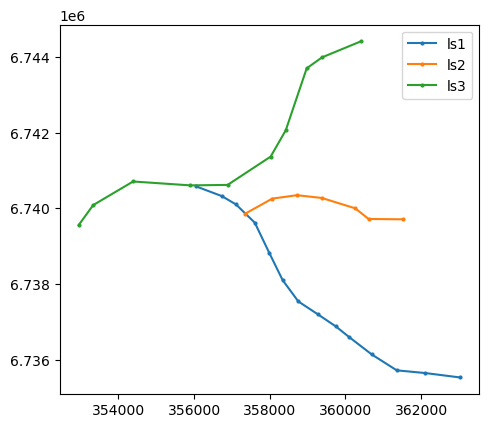

Number of drain cells =  119
the drain lengths are  [73.18417975374587, 100.34079429364797, 247.25433389324186, 81.23171072565516, 54.426122676654956, 60.94599452608454, 88.96225236885785, 134.04875894513697, 332.2821867541128, 173.9411259548167, 278.15835517828026, 275.91205725458326, 199.00398134668498, 300.3548151558398, 270.86176512742117, 212.69124131321894, 299.1262847311059, 292.81901682251527, 252.61340347839314, 68.44804707787834, 197.69081406343219, 199.36987721342294, 222.24352342788893, 200.80588874120244, 200.9689518331466, 361.6507727972232, 266.01939413005096, 282.23636619747185, 283.98601719148775, 220.4647839169075, 202.6568926865269, 202.65622390132592, 262.05191785555246, 197.33439082154953, 196.84842771638577, 181.81439372360566, 275.76284486265087, 184.82944589067958, 197.0163449383445, 196.83231797539534, 193.20167847552324, 195.59189984340006, 195.42424829016707, 186.1545761193439, 102.769339213866, 89.78744958646729, 116.72321388802, 141.17482765200725, 162.9763

In [41]:
from process_data import *
data = Data()

# DRAIN
setting = 'unconfined' # 'unconfined', 'surficial confinement', 'low permeability'

drain_linestrings = data.process_drn_linestrings(spatial)
drn_ibd, drn_cellids, drn_lengths = data.get_drain_cells(drain_linestrings, geomodel)
data.make_drain_rec(geomodel, setting, drn_cellids, drn_lengths)

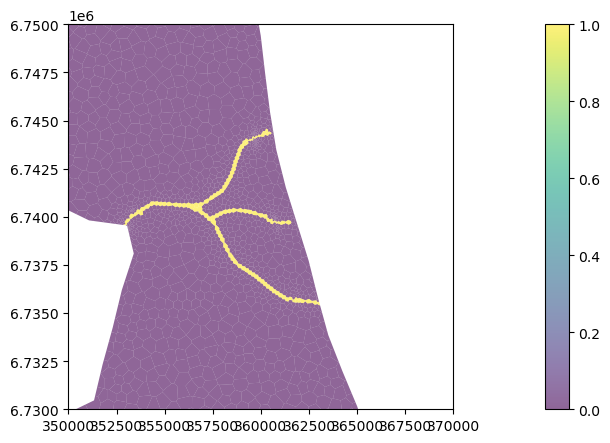

In [42]:
geomodel.plot_surface(drn_ibd, xlim = [350000, 370000], ylim = [6730000, 6750000]) # z0 = -200, z1 = 300

#### 10.2 CHD

In [43]:
#data.process_chd(geomodel, mesh)
#geomodel.plot_surface(data.chd_ibd, xlim = [350000, 356000], ylim = [6736000, 6742500]) 

#### 10.3 IC / RCH / EVT 

In [44]:
len(mesh.yc)

6013

In [45]:
mode = 'converge' # 'converge', 'steady', or 'transient'
setting = 'unconfined' # 'unconfined', 'surficial confinement', 'low permeability'
precipitation_df = pd.read_csv('../data/data_precipitation/precipitation_summary_classifications.csv') # This is the precipitation data for the model
steady_veg_json = '../data/data_woody/woody_cells/veg_1972_cells.json'

data.process_ic(geomodel)
data.process_rch(geomodel, mode, mesh, precipitation_df = precipitation_df, steady_veg_json = steady_veg_json)
data.process_evt(geomodel, mode, precipitation_df = precipitation_df, steady_veg_json = steady_veg_json)

Recharge is [((0, 0), 0.0001), ((0, 1), 0.0001), ((0, 2), 0.0001), ((0, 3), 0.0001), ((0, 4), 0.0001), ((0, 5), 0.0001), ((0, 6), 0.0001), ((0, 7), 0.0001), ((0, 8), 0.0001), ((0, 9), 0.0001), ((0, 10), 0.0001), ((0, 11), 0.0001), ((0, 12), 0.0001), ((0, 13), 0.0001), ((0, 14), 0.0001), ((0, 15), 0.0001), ((0, 16), 0.0001), ((0, 17), 0.0001), ((0, 18), 0.0001), ((0, 19), 0.0001), ((0, 20), 0.0001), ((0, 21), 0.0001), ((0, 22), 0.0001), ((0, 23), 0.0001), ((0, 24), 0.0001), ((0, 25), 0.0001), ((0, 26), 0.0001), ((0, 27), 0.0001), ((0, 28), 0.0001), ((0, 29), 0.0001), ((0, 30), 0.0001), ((0, 31), 0.0001), ((0, 32), 0.0001), ((0, 33), 0.0001), ((0, 34), 0.0001), ((0, 35), 0.0001), ((0, 36), 0.0001), ((0, 37), 0.0001), ((0, 38), 0.0001), ((0, 39), 0.0001), ((0, 40), 0.0001), ((0, 41), 0.0001), ((0, 42), 0.0001), ((0, 43), 0.0001), ((0, 44), 0.0001), ((0, 45), 0.0001), ((0, 46), 0.0001), ((0, 47), 0.0001), ((0, 48), 0.0001), ((0, 49), 0.0001), ((0, 50), 0.0001), ((0, 51), 0.0001), ((0, 52),

### 11. Groundwater observations for model calibration

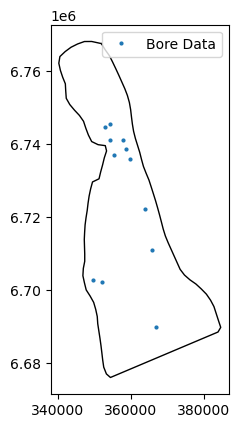

Site Ref Collect Date  Collect Month  Collect Year  \
0   61711381   1969-06-30              6          1969   
1   61711382   1969-06-30              6          1969   
2   61712850   1969-06-30              6          1969   
3   61712866   1969-06-30              6          1969   
4   61712877   1969-06-30              6          1969   
5   70111706   1969-06-30              6          1969   
6   70118002   1969-07-24              7          1969   
7   70118003   1969-07-24              7          1969   
8   70118006   1969-06-19              6          1969   
9   70118009   1969-07-24              7          1969   
10  70118010   1969-07-24              7          1969   
11  70118014   1969-07-24              7          1969   

   Depth Measurement Point  Static water level (m)  Water level (AHD) (m)  \
0             Ground level                   25.91                209.090   
1             Ground level                   16.76                213.670   
2             Ground level                   48.77                    NaN   
3             Ground level                   62.79                 19.510   
4             Ground level                   48.77                    NaN   
5             Ground level                   91.44                    NaN   
6            Top of casing                    8.51                214.604   
7            Top of casing                   15.83                215.419   
8            Top of casing                   -2.52                211.802   
9            Top of casing                    9.02                213.835   
10           Top of casing                   59.29                212.970   
11           Top of casing                   70.32                213.156   

    Water level (SLE) (m) Site Short Name    Easting    Northing  \
0                     NaN               9  349762.01  6702688.44   
1                     NaN       10 (No.2)  352269.02  6702226.45   
2                     NaN            Bore  367043.03  6689968.47   
3                     NaN            Bore  363811.03  6722277.47   
4                     NaN            Bore  365935.01  6710898.45   
5                     NaN            Bore  354409.02  6745612.49   
6                     NaN             AR7  357945.03  6741087.48   
7                     NaN             AR9  359751.05  6735767.49   
8                     NaN       AR12(ART)  354317.04  6741006.49   
9                     NaN            AR15  358795.04  6738632.49   
10                    NaN            AR16  355504.06  6737077.49   
11                    NaN            AR21  352934.03  6744728.49   

    Elevation_DEM        zobs  Derived WL (mAHD) Sample timeframe  
0      250.058762  231.768762         224.148762         1969_Wet  
1      255.148697  240.823697         238.388697         1969_Wet  
2      274.338226  243.858226         225.568226         1969_Wet  
3      275.898773  235.053773         213.108773         1969_Wet  
4      278.230713  245.465713         229.460713         1969_Wet  
5      299.811890  244.946890         208.371890         1969_Wet  
6      224.346420  167.956420         215.836420         1969_Wet  
7      233.731552  142.291552         217.901552         1969_Wet  
8      210.864594  129.194594         213.384594         1969_Wet  
9      223.021103  168.156103         214.001103         1969_Wet  
10     272.073059  154.268059         212.783059         1969_Wet  
11     284.180359  198.230359         213.860359         1969_Wet

In [46]:
#df = pd.read_csv('../data/data_waterlevels/obs/cleaned_obs_bores_KB.csv')
df = pd.read_excel('../data/data_waterlevels/obs/06_Steady_state_groundwater_obs.xlsx')
df = df[df['zobs'].notna()]

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Easting, df.Northing), crs=project.crs)
fig, ax = plt.subplots() 
ax.plot(gdf.geometry.x, gdf.geometry.y, 'o', ms = 2, label = 'Bore Data')  # You can set color, linestyle, etc.
x, y = spatial.model_boundary_poly.exterior.xy
ax.plot(x, y, '-', ms = 2, lw = 1, color='black')
ax.set_aspect('equal')
ax.legend()
plt.show()

df

In [47]:
import process_observations
gdf = process_observations.make_obs_gdf(df, geomodel, mesh, spatial)

print(gdf.columns)

All geometries are within the polygon.
Index(['id', 'Collect Date', 'Collect Month', 'Collect Year',
       'Depth Measurement Point', 'Static water level (m)',
       'Water level (AHD) (m)', 'Water level (SLE) (m)', 'Site Short Name',
       'x', 'y', 'Elevation_DEM', 'z', 'Derived WL (mAHD)', 'Sample timeframe',
       'geometry', 'icpl', 'ground', 'model_bottom', 'zobs-bot', 'cell_disv',
       'cell_disu', '(lay,icpl)', 'lay', 'obscell_xy', 'obscell_z',
       'obs_zpillar', 'geolay'],
      dtype='object')


In [48]:
from loopflopy.observations import Observations
observations = Observations(gdf)
observations.make_recarray() # makes recarray for flowmodel

observations.obs_rec

[[61711381, 'head', 4811],
 [61711382, 'head', 4357],
 [61712850, 'head', 11253],
 [61712866, 'head', 1913],
 [61712877, 'head', 2948],
 [70111706, 'head', 7408],
 [70118002, 'head', 6373],
 [70118003, 'head', 13196],
 [70118006, 'head', 12322],
 [70118009, 'head', 7108],
 [70118010, 'head', 19574],
 [70118014, 'head', 13410]]

### 12. Create and run steady-state flow model

In [49]:
# I've made your own flowmodel script as I'm sure you'll find the LoopFlopy one a bit too restricitive.
# Now you can change the flowmodel however you want!

from Otorowiri_flowmodel import *

scenario = 'steadymodel'
fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
data
geomodel
lith
logk11
logk33
mesh
observations
project
scenario


In [50]:
geomodel.top_geo[4]

np.float64(242.76951599121094)

In [51]:
geomodel.idomain[(0,0)]

np.int64(1)

In [52]:
print(fm.geomodel.iconvert) # Check the iconvert is set correctly
print(len(fm.geomodel.iconvert))
print(fm.geomodel.iconvert.shape)
print(fm.geomodel.iconvert.dtype)
print(fm.geomodel.ncpl * fm.geomodel.nlay) # Number of cells in the model

[0. 0. 0. ... 0. 0. 0.]
24052
(24052,)
float64
24052


In [53]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = False, #not necessary when all model boundaries have implied boundary conditions
                         wel = False, 
                         obs = True, #put false to not record heads at the chosen cells
                         rch = True, 
                         evt = True, 
                         drn = True, 
                         ghb = False, 
                         xt3d = True,
                         staggered = False, # True made "fully connected". "False" is essentially DISV.
                        )

fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
xt3d =  True
mf6 executable expected:  ../exe/mf6.exe
   Time taken to write flow model =  11.947973
Running simulation for  steadymodel  ...
Model success =  False
   run_time =  13.556061
   Re-writing IMS - Take 2
Model success2 =  False
   Re-writing IMS - Take 3
Model success3 =  True
['DISU', 'NPF', 'IC', 'RCH_0', 'EVT_0', 'DRN_0', 'OBS_0', 'OC']
head results shape  (1, 24052)


In [55]:
print(flopy.__version__)

3.8.2


In [83]:
fm.geomodel.ncell_disu

24052

In [89]:
fm.disu_gridprops.keys()

dict_keys(['nodes', 'top', 'bot', 'area', 'iac', 'nja', 'ja', 'cl12', 'ihc', 'hwva', 'angldegx', 'nvert', 'vertices', 'cell2d'])

In [95]:
fm.mesh.xc

(np.float64(351979.77915992),
 np.float64(353023.0836772708),
 np.float64(354182.3829498707),
 np.float64(355057.7939010282),
 np.float64(355917.91143839585),
 np.float64(356759.21644385654),
 np.float64(357572.45686653914),
 np.float64(358388.1769214386),
 np.float64(359101.4948365394),
 np.float64(359643.4794036094),
 np.float64(359988.0029334753),
 np.float64(360218.8846461062),
 np.float64(360470.8040349628),
 np.float64(360798.74606355396),
 np.float64(361288.8763441413),
 np.float64(361884.0260659813),
 np.float64(362479.17578782124),
 np.float64(362966.1542870327),
 np.float64(363498.8682428432),
 np.float64(364228.3141929437),
 np.float64(365001.96739612735),
 np.float64(365621.80669659),
 np.float64(366228.58964337286),
 np.float64(366826.12461494206),
 np.float64(367379.6260604368),
 np.float64(367910.0241889547),
 np.float64(368415.78556704),
 np.float64(368912.0821532651),
 np.float64(369503.1348262483),
 np.float64(370265.1717394483),
 np.float64(371086.33606031083),
 np.f

In [97]:
###check grid connectivity
gwf = sim.get_model("steadymodel")
disu = gwf.get_package("disu") # Get the DISU package from the GWF model

from loopflopy.utils import check_connectivity_disu

labels = check_connectivity_disu(fm, idomain=gwf.modelgrid.idomain, plot = True)

Number of cells in the model: 24052
iac len is: 24052
Number of connections in the model: 201386
Found 1 connected component(s)


Node one based =  4 Node zero based =  3
XYZ problem =  355057.7939010282 6762433.641536581 211.54530556996664
cell width approx  1053.9865605208324
cell length approx  1786.255890761502
cell thickness 32.97317059834796
lay, icpl (0, 3)


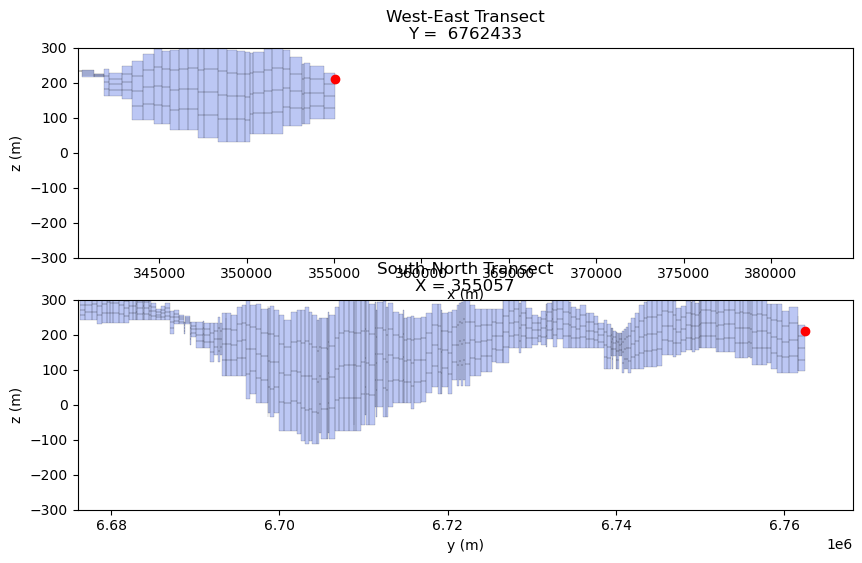

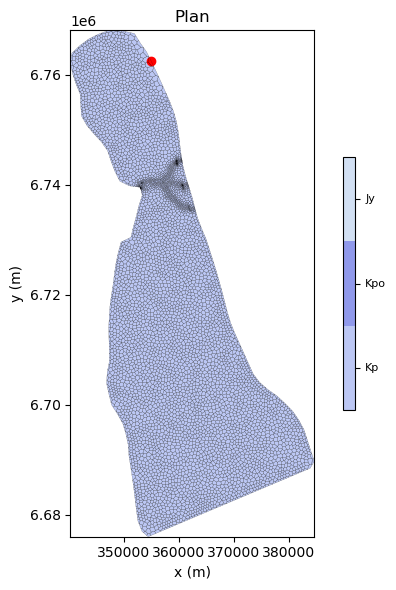

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

'0   71   72   73   82   83   84   85   86   87   88   89   99  101\n  102  103  104  105  106  107  108  109  110  111  112  113  114  188\n  189  204  213  218  219  225  226  461 1321 1376 1486 1488 1489 1490\n 1491 1492 1493 1494 1495 1515 1517 1518 1519 1520 1522 1523 1524 1525\n 1526 1527 1528 1529 1531 1532 1533 1534 1536 1538 1541 1543 1545 1546\n 1548 1706 1707 1712 1873 1912 1913 1915 1917 1918 1919 1920 1923 1925\n 1927 1930 1975 2011 2013 2015 2016 2017 2018 2019 2081 2082 2260 2343\n 2344 2345 2346 2347 2349 2351 2353 2357 2359 2360 2362 2364 2366 2370\n 2372 2374 2375 2377 2380 2381 2384 2389 2391 2392 2395 2398 2400 2401\n 2402 2403 2411 2413 2970 2971 2976 2977 2978 2979 2980 2981 2983 2985\n 2986 2987 2992 2993 2995 2996 2998 2999 3000 3001 3002 3003 3004 3008\n 3009 3010 3011 3012 3013 3015 3018 3020 3023 3026 3034 3291 3298 3525\n 3526 4888 4891 4896 4898 4901 4903 4904 4907 4909 4934 4935 5056 5057\n 5058 5059 5060 5061 5062 5073 5581 5982'

In [103]:
utils.plot_node(3, geomodel, structuralmodel, spatial, sim, scenario, features) # array needs to be a string of a property eg. 'k11'
for icpl in range(geomodel.ncpl):
    print(icpl)
'''0   71   72   73   82   83   84   85   86   87   88   89   99  101
  102  103  104  105  106  107  108  109  110  111  112  113  114  188
  189  204  213  218  219  225  226  461 1321 1376 1486 1488 1489 1490
 1491 1492 1493 1494 1495 1515 1517 1518 1519 1520 1522 1523 1524 1525
 1526 1527 1528 1529 1531 1532 1533 1534 1536 1538 1541 1543 1545 1546
 1548 1706 1707 1712 1873 1912 1913 1915 1917 1918 1919 1920 1923 1925
 1927 1930 1975 2011 2013 2015 2016 2017 2018 2019 2081 2082 2260 2343
 2344 2345 2346 2347 2349 2351 2353 2357 2359 2360 2362 2364 2366 2370
 2372 2374 2375 2377 2380 2381 2384 2389 2391 2392 2395 2398 2400 2401
 2402 2403 2411 2413 2970 2971 2976 2977 2978 2979 2980 2981 2983 2985
 2986 2987 2992 2993 2995 2996 2998 2999 3000 3001 3002 3003 3004 3008
 3009 3010 3011 3012 3013 3015 3018 3020 3023 3026 3034 3291 3298 3525
 3526 4888 4891 4896 4898 4901 4903 4904 4907 4909 4934 4935 5056 5057
 5058 5059 5060 5061 5062 5073 5581 5982'''


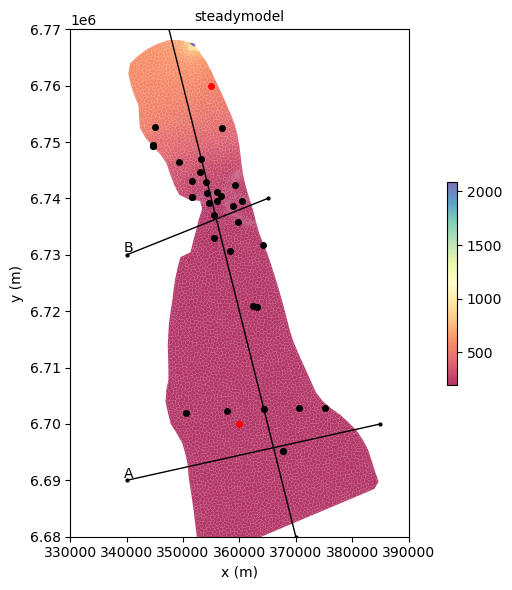

In [54]:
watertable = fm.get_watertable(geomodel, fm.head)

extent = [[330000, 390000],[6680000, 6770000]]
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable, extent = extent, xsections = True,)#vmin = -10, vmax = 150)#, extent, vmin, vmax

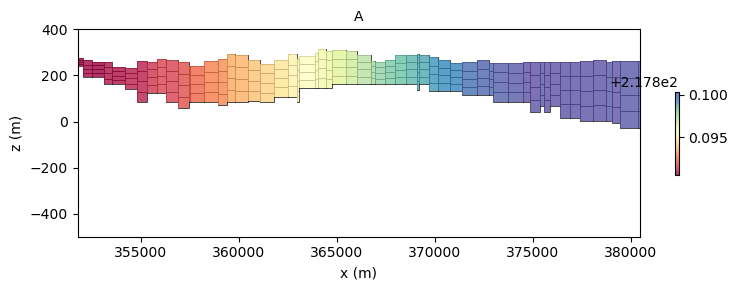

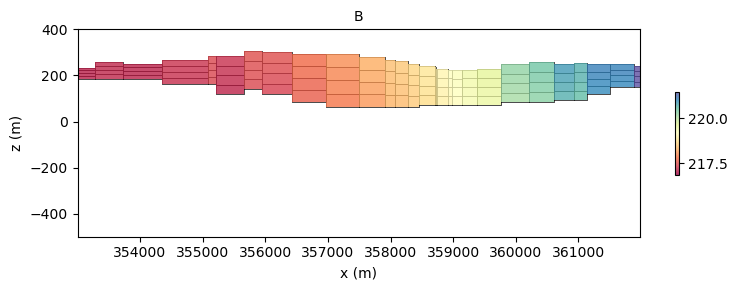

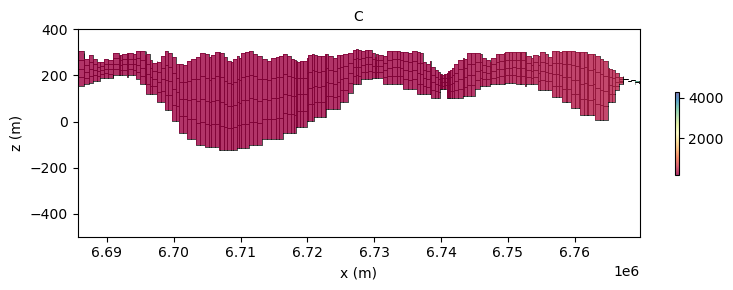

In [55]:
for i in range(len(spatial.xsections)):
    start = spatial.xsections[i][0]
    end   = spatial.xsections[i][1]
    title = spatial.xsection_names[i]

    fm.plot_transect(spatial, 
                     structuralmodel, 
                     array = 'head',  
                     title = title,
                    z0 = -500, z1 = 400, 
                    x0 = start[0], x1 = end[0], 
                    y0 = start[1], y1 = end[1])

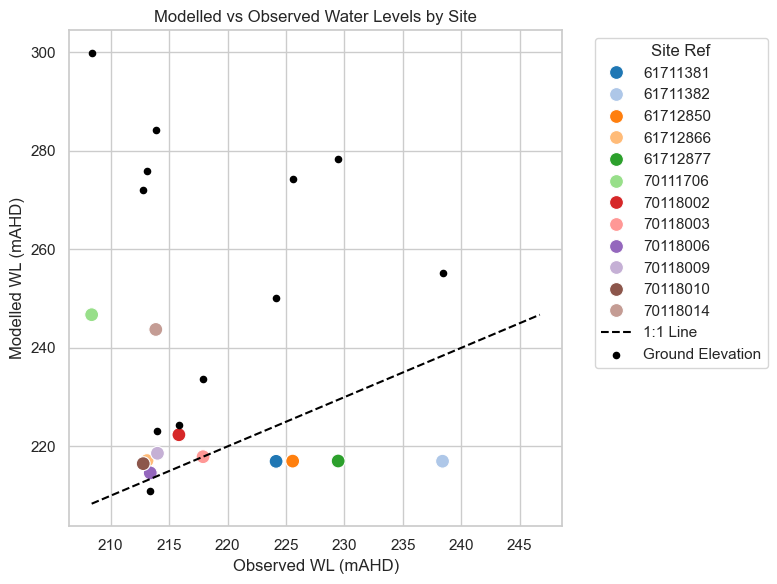

In [129]:
import process_modelvisuals

# plot the observed and modelled heads
observed_df = pd.read_excel('../data/data_waterlevels/obs/06_Steady_state_groundwater_obs.xlsx')
modelled_df = pd.read_csv('../modelfiles/steadymodel_observations.csv')

#print(observed_df.columns)
#print(observed_df)
#print(modelled_df.columns)

process_modelvisuals.plot_steady_state(observed_df, modelled_df)

### 13. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fmss.head
flowmodel = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
flowmodel.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

NameError: name 'wel_qlay' is not defined

In [ ]:
sim = flowmodel.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

In [ ]:
flowmodel.run_flowmodel(sim, transient = True)

In [ ]:
watertable = flowmodel.get_watertable(geomodel, flowmodel.head)

### 12. Visualise Results

In [ ]:
import plotting_routines

vmin, vmax = 495, 505 #min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, flowmodel, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, flowmodel, array, X0, X1, Y0, Y1)#, vmin, vmax)

# PLOT BY LAYER
#from plotting_routines import plot_plan
#array = 'head'
#layer = 0
#plot_plan(spatial, mesh, flowmodel, array, layer, extent = extent, vmin=vmin, vmax=vmax, vectors = True)

### 13. Forecasting

In [ ]:

class Forecast:
    def __init__(self, name):
        self.name = name

forecast = Forecast('forecast_scenario_1')
forecast.qwell = [-200000, -200000] #m3/d 


In [ ]:
scrap code

# FOR TRANSIENT
rch_list = []
for index, row in df.iterrows(): 
    for i in range(4,16): # Jan-Dec
        rch_list.append(row.iloc[i]/1000) # mm to m

nper = len(rch_list)
ncpl = len(cell2d)

# FOR HFB IF WE USE

# import disv2disu # MODFLOW Tools
# Disv2Disu = disv2disu.Disv2Disu    
# nlay = 1
# botm = np.zeros_like(top).reshape(1, len(cell2d))
# idomain = np.ones_like(top).reshape(1, len(cell2d))
# dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=False, disv_idomain = idomain)
# dv2d._neighbors
# #dv2d._edge_set
# 
# dyke_K, dyke_width = 0.0001, 2  
# hydchr = dyke_K / dyke_width  
# 
# # Set up Horizontal Flow Barrier (HFB)
# for n in range(gdf.shape[0]): # For each dyke...
#     # Vertical
#     for lay in range(nlay):
#         for cell ibd[cell]
#         if zc[lay, icpl] < dyke_top[n]: 
#             hfb.append(([lay, cellid_1], [k, cellid_2], hydchr))

#### FAULT
#P.fault_buffer = 800

# Import fault shape file
#bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
#bada_shp.to_crs(epsg=28350, inplace=True)
#bada_shp = gpd.clip(bada_shp, model_boundary)

#from meshing_routines import prepare_fault_nodes_voronoi
#fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [ ]:
# METHOD BARDOT 2024
from meshing_routines import resample_linestring
import itertools
from datetime import datetime

t0 = datetime.now()

def voronoi_nodes_gdf(gdf, refinement_boundary_poly, buffer):

    dyke = []
    hfb_1, hfb_2 = [], []
    nodes = []
    
    for n in range(gdf.shape[0]): 
        
        # Dykes notes (on the dyke linestring)
        linestring = dykes_gdf.geometry[n]
        r = 2*buffer/3 # distance between points
        ls_resample = resample_linestring(linestring, r) # resample orginal dyke line
        dyke.append(ls_resample)
        
        # Refinement nodes
        offsets = [-1.5*r, -0.5*r, 0.5*r, 1.5*r]
        fault_offset_lines = []
        for i, offset in enumerate(offsets):
            ls = linestring.parallel_offset(offset) # linestring.parallel_offset
            ls_resample = resample_linestring(ls, r)
            
            p = []
            for point in ls_resample:
                x,y = point.x, point.y
                p.append((x,y))
                #if refinement_boundary_poly.contains(point):
                #    x,y = point.x, point.y
                #    p.append((x,y))
            
            if len(p) != 1: # just incase there is a 1 point linestring
                offset_ls = LineString(p)
                coords = list(offset_ls.coords)
                fault_offset_lines.append(coords) 
                if i == 1: # SIDE 1
                    hfb_1.append(coords)
                if i == 2: # SIDE 2
                    hfb_2.append(coords)
                
        nodes.append([tup for line in fault_offset_lines for tup in line]) 
    refinement_nodes = list(itertools.chain.from_iterable(nodes))

    return(refinement_nodes, hfb_1, hfb_2)

# Import dykes shape file
dykes_gdf = gpd.read_file('../data_shp/dykes_m.shp')
dykes_gdf.to_crs(epsg=28350, inplace=True)
dykes_gdf = gpd.clip(dykes_gdf, inner_boundary_poly).reset_index(drop=True)
#dykes_gdf.plot()

dyke_nodes, hfb_1, hfb_2 = voronoi_nodes_gdf(dykes_gdf, refinement_boundary_poly, buffer)

t1 = datetime.now()
print(t1 - t0) 

In [ ]:

from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.2, allow_holes = False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

def plot_geology_polygons(gdf, hull_gdf):
    # Plot results
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.legend()
    plt.show()

for i in range(7):
    gdf, hull_gdf = create_surfacegeo_polys(geomodel, i)
    plot_geology_polygons(gdf, hull_gdf)

In [ ]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

# Interpolate onto a structured grid
from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
loopmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
# loopmesh
#dx, dy = 1000, 1000 # 1000m cells
#nx = int((structuralmodel.x1 - structuralmodel.x0)/dx)
#ny = int((structuralmodel.y1 - structuralmodel.y0)/dy)
#structured2d = StructuredGrid2D(origin=[structuralmodel.x0, structuralmodel.y0], nsteps=[nx, ny], step_vector= [dx, dy])
pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
z = loopmesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
np.unique(z)
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

surface = structuralmodel.model['Ground'].surfaces([0])[0]
#surfaces = structuralmodel.model.get_stratigraphic_surfaces(units = ['Ground'])
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()
for s in surfaces:
    p.add_mesh(s.vtk())
p.add_points(surface.vertices)
#p.add_mesh(surfaces[0].vtk)
p.show()

from LoopStructural.visualisation import Loop3DView
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=geomodel.vgrid)
arr = pmv.plot_array(geomodel.idomain[0], alpha = 0.6) #(M.botm_geo[0], alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
cbar = fig.colorbar(arr, ax=ax, shrink = 0.5)  